# Homework 3 CSCI 4364/6364 Machine Learning

##**A Tour of Multivariate Classification**

**Due Date: 10/17/2023, 23:59 ET**

---

**Purpose:**
This homework will provide you with hands-on experience with some of the multivariate classification algorithms we discussed in class and expose you to one of the most cited datasets, MNIST.

You should get a broad appreciation for the various approaches to classification that will help you evaluate which approach is best for your real world research or industry application.

The [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. MNIST is a good dataset for this assignment, since it has 10 classes (0 - 9) with a large number of features.


---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

> **Important:** Please save and submit your homework assignment notebook with outputs. You can do this by selecting `Edit` >> `Notebook settings` and making sure the option `Omit code cell output when saving this notebook` is **NOT** selected.

**Grading on the notebook:**
This notebook is worth up to 5% (with up to 3% additional extra credit) of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Coding Standards:**
Throughout this course, we will use [Google’s Python Style Guide](https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Sowmya Vara





**GW ID:** G44613640

In [1]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
from sklearn.datasets import fetch_openml
from keras.utils import to_categorical
import numpy as np
import time
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from typing import Dict, Optional
import tensorflow as tf
from gc import callbacks

First, download the MNIST data using the code provided below.

Here are the first 9 digits of the MNIST data with label.


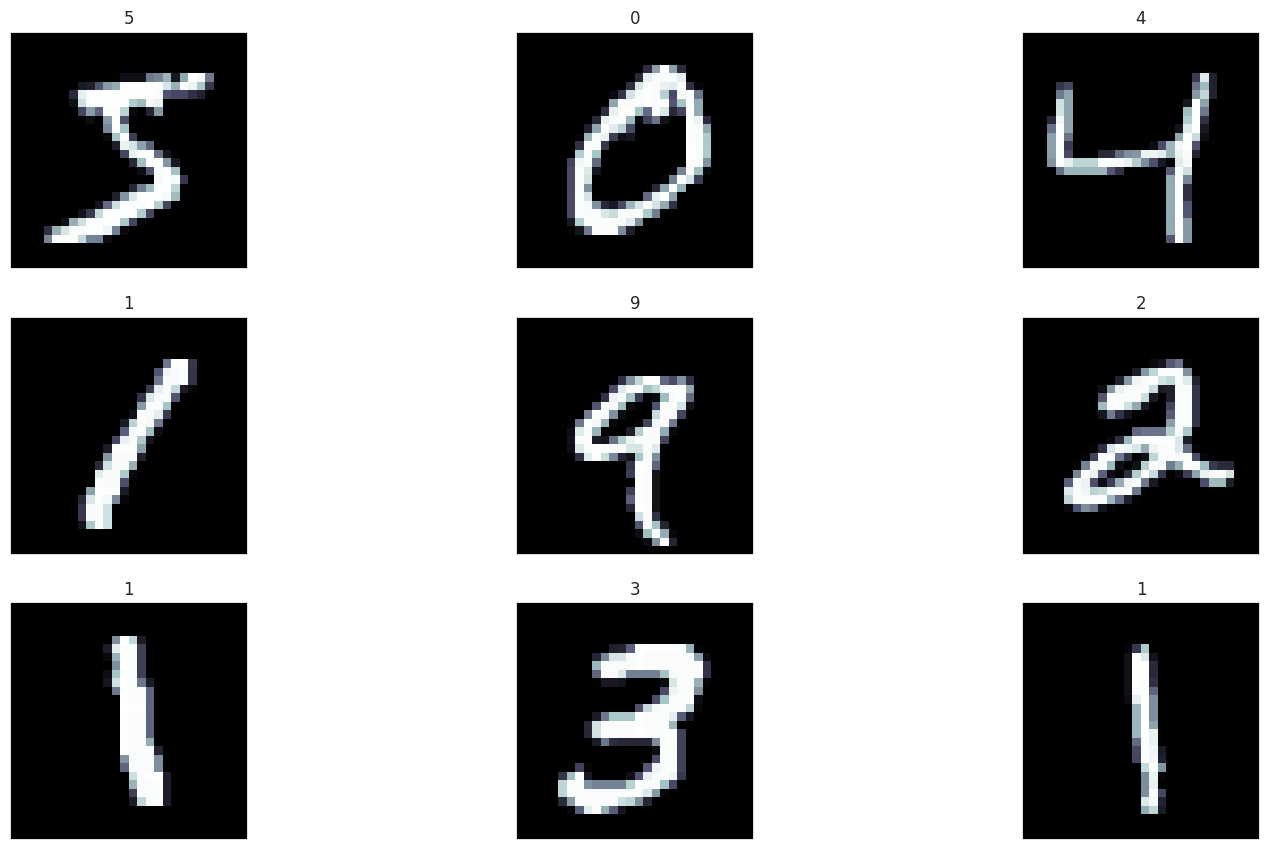

In [2]:
#@title Download MNIST, split, and plot example
def plot_example(x_raw, y_raw):
  fig, axes = plt.subplots(3, 3)
  i = 0
  for i in range(3):
    for j in range(3):
      imgplot = axes[i,j].imshow(x_raw[i*3 + j].reshape((28,28)), cmap = 'bone')
      axes[i,j].set_title(y_raw[i*3 + j])
      axes[i,j].get_yaxis().set_visible(False)
      axes[i,j].get_xaxis().set_visible(False)
  fig.set_size_inches(18.5, 10.5, forward=True)


x_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True, parser = 'auto')
x = (x_raw/255).astype('float32').to_numpy()

# Split the data set into train, validation, and test sets.
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y_raw, test_size=0.10, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.10, random_state=42)
print('Here are the first 9 digits of the MNIST data with label.')
plot_example(x, y_raw)

As in the past assignments, we'll define our base learning algorithm class, and create multiple implementations. Here, in the fit (or train) method, along with x_train and y_train, we'll include x_val, and y_val, as validation sets. Not all implementations will use them.

In [3]:
np.shape(x)

(70000, 784)

In [3]:
#@title Define a base class class for Learning Algorithm

class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def fit(self, x_train:np.array, y_train: np.array
          , x_val:np.array
          , y_val:np.array) -> None:
    """Trains a model from labels y and examples X.
    We include validation set for optional hyperparameter tuning. Not
    all of the algorithims we use will
    """

  @abstractmethod
  def predict(self, x_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""

Next, we want to establish a common approach to evaluating our implementations of `BaseLearningAlgorithm`.

A **Confusion Matrix** is a data table that helps visualize the performance of a multi-class classifier. The rows represent the true class assignmants from the test set labels, and the columns represent the predicted classes generated by the classifier. A perfect classifier will only populate the diagonal with counts and all off-diagonal elements of the matrix will be zero. Off-diagonal counts indiate that the model confuses the class in row $i$ with the class in column $j$. For example, in MNIST, the number $9$ might be confused $4$, and the associated cell at $i, j$ will be greater than $0$.

Besides precision and accuracy, the **F1-Score** is often used.  Review this [Wikipedia article](https://en.wikipedia.org/wiki/F-score) on F-Score.

##Question 1.
The Wikipedia article indicates that one weakness of the F-Score is that it assigns equal importance to precision and recall. Describe two scenarios where (a) precision may be more important to recall, and (b) where recall may be more important than precision.

## Answer

The scenario in which **precision is more important than recall** is when the cost of a false positive is high and we want to minimize those number of false positives. This is because false positives can have serious consequences, such as unnecessary **treatment in a medical diagnosis system** where it is more important to have a system that is precise, even if it means missing some true positives.
Also, in **fraud detection systems**, high precision is required to avoid false positives that could compromise a business's reputation.

**-->** Like, in a a credit card fraud detection system,a false positive (a legitimate transaction being flagged as fraudulent) could inconvenience the customer and potentially damage the reputation of the credit card company.

On the other hand, the scenario in which **recall is more important than precision** is when the cost of a false negative is high i.e., when we want to minimize the number of false negatives.

For example, in **medical diagnosis systems**, recall may become especially important where missing positive cases could have severe consequences or be life-threatening.

**-->** Like, in in a disease outbreak detection system, a false negative (a missed case of the disease) could lead to the spread of the disease and potentially cause an epidemic.

In [4]:
#@title Define a basic train and evaluation pipeline
def train_eval(learning_algo: BaseLearningAlgorithm, x_train, y_train,x_val, y_val, x_test, y_test):
  """Trains and evaluates the generic model."""
  learning_algo.fit(x_train, y_train, x_val, y_val)
  y_pred = learning_algo.predict(x_test)
  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc = {'figure.figsize':(8,8)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(10)],
              yticklabels=['%d' %i for i in range(10)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)

  print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(10)]))

#1. Linear model with Logistic Regression
Let's start with basic logistic regression and demonstrate that Logistic Regression works on a multiclass classification problem.

We'll use the familiar least squares regression model with L2 regularization as a baseline for comparison.

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       683
           1       0.94      0.97      0.96       800
           2       0.90      0.89      0.90       674
           3       0.89      0.89      0.89       760
           4       0.92      0.93      0.92       611
           5       0.89      0.88      0.89       658
           6       0.94      0.95      0.94       677
           7       0.93      0.94      0.93       724
           8       0.90      0.86      0.88       693
           9       0.92      0.90      0.91       720

    accuracy                           0.92      7000
   macro avg       0.92      0.92      0.92      7000
weighted avg       0.92      0.92      0.92      7000

CPU times: user 8min 29s, sys: 29.6 s, total: 8min 58s
Wall time: 5min 14s


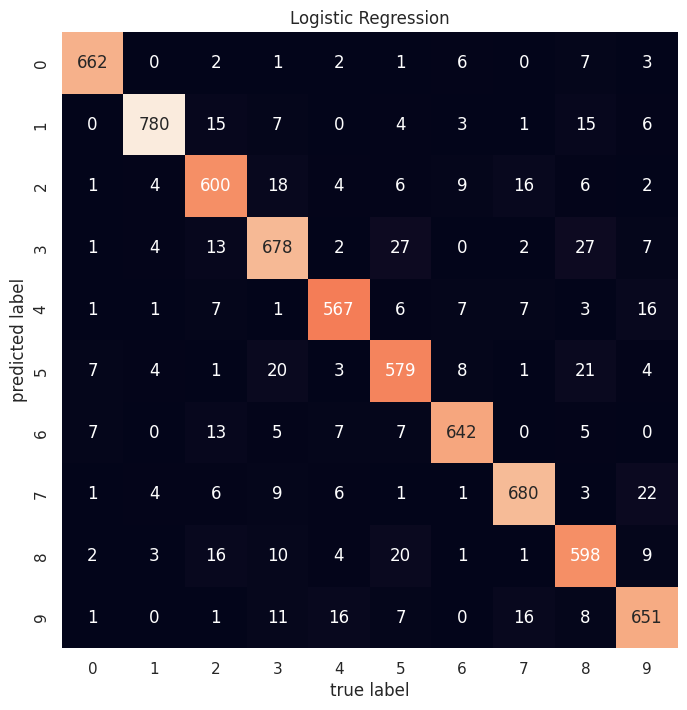

In [6]:
#@title Define the basic Logistic Regression Model

class LogisticRegressionLearningAlgorithm(BaseLearningAlgorithm):
  """Minimalist wrapper class for basic Logistic Regression."""

  def __init__(self, max_iters: int = 1000):
    self._model = LogisticRegression(max_iter = max_iters, verbose = True, penalty = 'l2')

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self._model.fit(x_train,y_train)


  def predict(self, x_test: np.array) -> np.array:
    return self._model.predict(x_test)

  @property
  def name(self) -> str:
    return 'Logistic Regression'

learning_algo = LogisticRegressionLearningAlgorithm(max_iters = 1000)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

**Confusion pairs of Logistic Regression**

In [8]:
y_pred = learning_algo.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Identify the top 3 pairs of confusion
top_3_pairs = []
for i in range(cm.shape[0]):
  for j in range(i + 1, cm.shape[1]):
    top_3_pairs.append((i, j, cm[i, j]))

# Sort the pairs of classes by the number of misclassifications, in descending order
top_3_pairs = sorted(top_3_pairs, key=lambda x: x[2], reverse=True)

# Print the top 3 pairs of confusion
print('Top 3 pairs of confusion for Logistic Regression:')
for i in range(3):
  print('Class {} vs. Class {}: {} misclassifications'.format(top_3_pairs[i][0], top_3_pairs[i][1], top_3_pairs[i][2]))

Top 3 pairs of confusion for Logistic Regression:
Class 3 vs. Class 5: 20 misclassifications
Class 5 vs. Class 8: 20 misclassifications
Class 2 vs. Class 8: 16 misclassifications


#2. Support Vector Machine + Principal Components Analysis
In this section, we'll investigate the Support Vector Machine with and without dimensionality reduction using PCA.

##2.1 Basic SVM (Task 1)
In the block below, use Scikit-Learn's SVM classifier, SVC. Configure the SVC with a Radial Basis Function Kernel (RBF), and parameterize the cost value and the RBF gamma parameter.

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.94      0.98      0.96       800
           2       0.92      0.92      0.92       674
           3       0.91      0.90      0.90       760
           4       0.89      0.94      0.92       611
           5       0.90      0.90      0.90       658
           6       0.95      0.96      0.96       677
           7       0.95      0.94      0.95       724
           8       0.94      0.88      0.91       693
           9       0.93      0.91      0.92       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 9min 52s, sys: 706 ms, total: 9min 53s
Wall time: 10min 1s
Top 3 pairs of confusion:
Class 4 vs. Class 9: 24 misclassifications
Class 3 vs. Class 5: 23 misclassifications
Class 2 vs. Class 4: 11 misclassifications


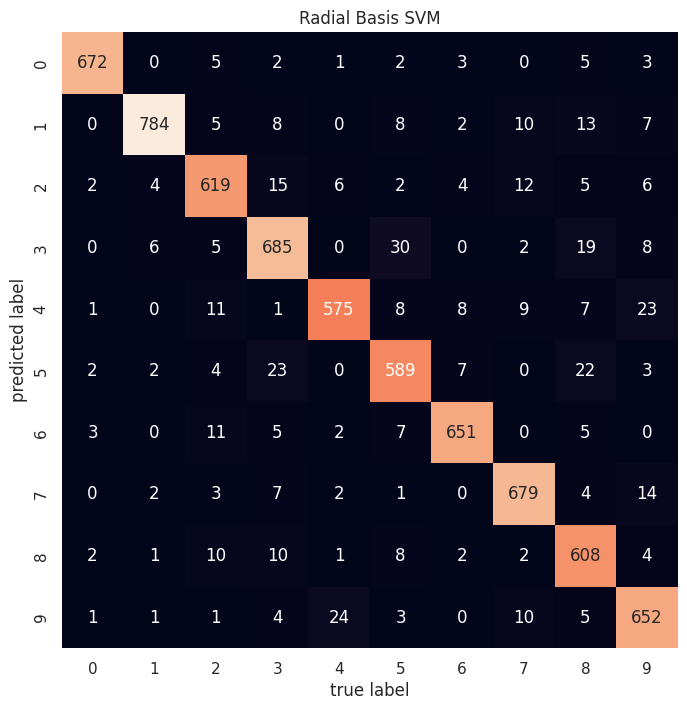

In [9]:
class RadialBasisSvmLearningAlgorithm(BaseLearningAlgorithm):
  """RBF SVM Classifier function."""

  def __init__(self, cost: float, gamma: float):
      self.clf = SVC(kernel='rbf', C=cost, gamma = gamma)

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
      self.clf.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
      return self.clf.predict(x_test)

  @property
  def name(self) -> str:
    return 'Radial Basis SVM'

learning_algo = RadialBasisSvmLearningAlgorithm(cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

y_pred = learning_algo.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Identify the top 3 pairs of confusion
top_3_pairs = []
for i in range(cm.shape[0]):
  for j in range(i + 1, cm.shape[1]):
    top_3_pairs.append((i, j, cm[i, j]))

# Sort the pairs of classes by the number of misclassifications, in descending order
top_3_pairs = sorted(top_3_pairs, key=lambda x: x[2], reverse=True)

# Print the top 3 pairs of confusion
print('Top 3 pairs of confusion:')
for i in range(3):
  print('Class {} vs. Class {}: {} misclassifications'.format(top_3_pairs[i][0], top_3_pairs[i][1], top_3_pairs[i][2]))

##2.2 Dimensionality Reduction with PCA (Task 2)

Next, we'll use PCA to reduce the input space from 784 dimensions to lower dimensions with lower variance. But how how many dimensions do we choose to keep? To help deceide that, we should first plot out the explained varaince by the number of singular values. This gives us picture of how much information is lost by removing the smallest singular values.  

In the code below, use Scikit-Learn's PCA class with `x_train` and plot out the explained variance ratio against the number of components (singular values).  

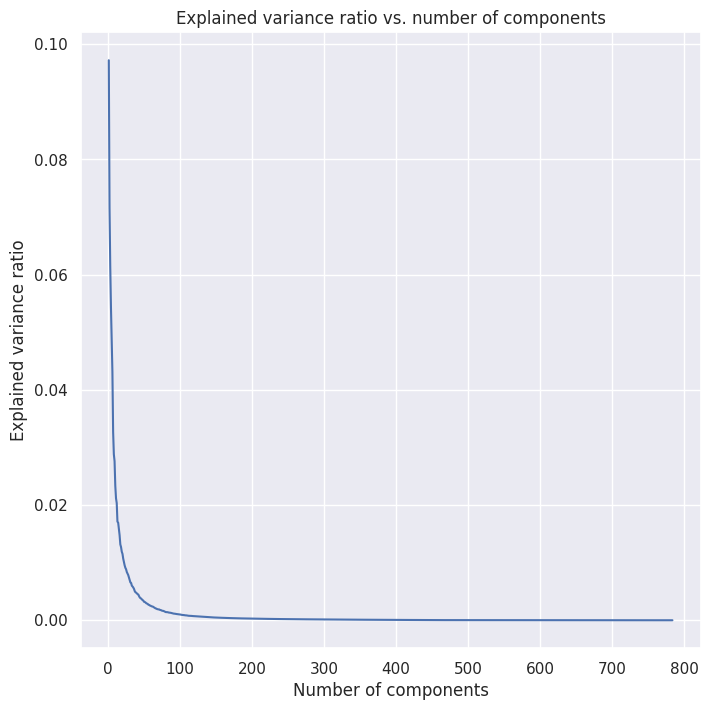

In [ ]:
#@title Fit PCA and plot the explained variance as a function of components
# Create a PCA object
pca = PCA()

# Fit the PCA object to the training data
pca.fit(x_train)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Get the number of components
n_components = len(explained_variance_ratio)

# Plot the explained variance ratio against the number of components
plt.plot(np.arange(n_components) + 1, explained_variance_ratio)
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.title("Explained variance ratio vs. number of components")

plt.show()

More clear graph

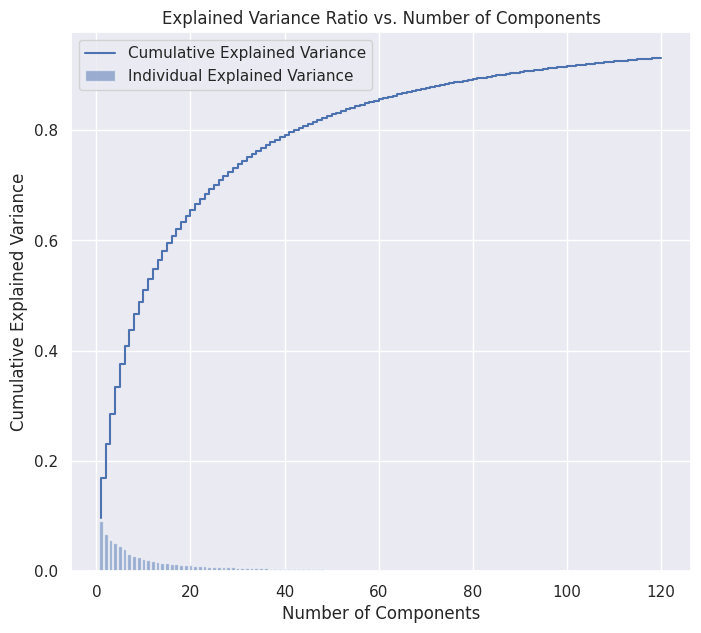

In [7]:
pca = PCA(n_components=120)
principal_components = pca.fit_transform(x_train)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

num_components = len(explained_variance_ratio)
x = np.arange(1, num_components + 1)

plt.figure(figsize=(8, 7))

plt.step(x, cumulative_explained_variance, label='Cumulative Explained Variance')
x_ticks = np.arange(0, num_components + 1, 20)

#individual explained variances
individual_explained_variances = explained_variance_ratio * np.sum(explained_variance_ratio)

# Plotting individual explained variances as a bar chart
plt.bar(x, individual_explained_variances, alpha=0.5,label='Individual Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.xticks(x_ticks)
plt.legend(loc ='best')
plt.grid(True)
plt.show()


In [8]:
# 90% variance
pca= PCA(.90)
pca.fit(x_train)
print('Number of components to explain 90% Variance is',pca.n_components_)

Number of components to explain 90% Variance is 87


In [9]:
# 80% variance
pca=PCA(.80)
pca.fit(x_train)
print('Number of components to explain 80% Variance is',pca.n_components_)

Number of components to explain 80% Variance is 43


##Question 2.
Based on the variance vs. num components chart above, how many components represent 80% and 90% of the explained variance?

## Answer
80%: 43 components
90%: 87 components

43 components represent the 80% of the explained variance. And, 87 components represent the 90% of the explained variance.

This can be determined by looking for the points on the plot where the cumulative explained variance reaches 80% and 90%, respectively.

##2.2 Apply PCA to reduce dimensionality for SVM (Task 3)

In the code block below, extend the basic SVM class from 2.1 and name it `RadialBasisSvmPcaLearningAlgorithm` that first reduces the dimension. You can use Scikit-Learn's `make_pipeline()` method to combine PCA and SVC into a pipeline.

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       683
           1       0.92      0.98      0.95       800
           2       0.90      0.89      0.90       674
           3       0.89      0.86      0.87       760
           4       0.89      0.93      0.91       611
           5       0.86      0.88      0.87       658
           6       0.93      0.95      0.94       677
           7       0.94      0.93      0.93       724
           8       0.91      0.83      0.87       693
           9       0.91      0.88      0.89       720

    accuracy                           0.91      7000
   macro avg       0.91      0.91      0.91      7000
weighted avg       0.91      0.91      0.91      7000

CPU times: user 1min 23s, sys: 1.46 s, total: 1min 24s
Wall time: 1min 23s
Top 3 pairs of confusion:
Class 3 vs. Class 5: 32 misclassifications
Class 4 vs. Class 9: 26 misclassifications
Class 2 vs. Class 6: 17 misclassifications


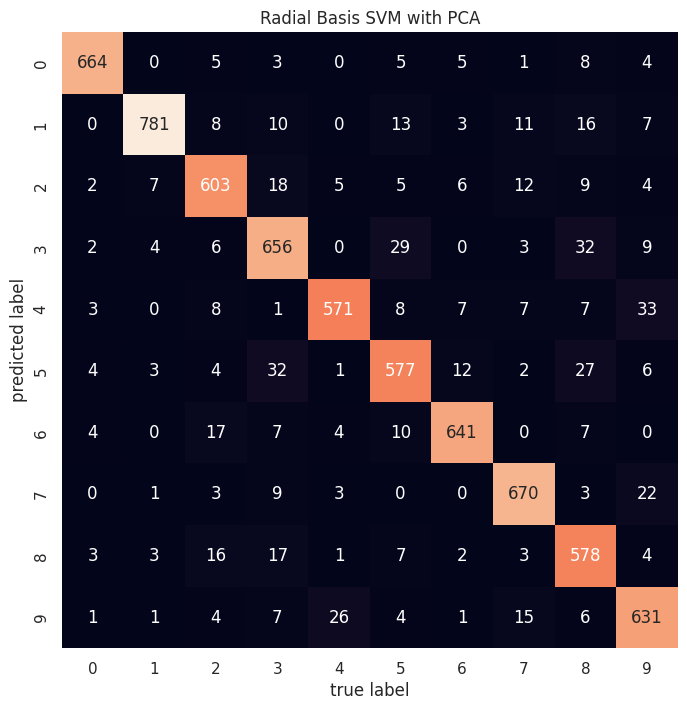

In [10]:
class RadialBasisSvmPcaLearningAlgorithm(BaseLearningAlgorithm):
  def __init__(self, n_components: int, cost: float, gamma: float):
    self.pipeline = make_pipeline(PCA(n_components=n_components), SVC(kernel='rbf', C=cost, gamma=gamma))

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self.pipeline.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
    return self.pipeline.predict(x_test)

  @property
  def name(self) -> str:
    return 'Radial Basis SVM with PCA'


learning_algo = RadialBasisSvmPcaLearningAlgorithm(n_components=30, cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


y_pred = learning_algo.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Identify the top 3 pairs of confusion
top_3_pairs = []
for i in range(cm.shape[0]):
  for j in range(i + 1, cm.shape[1]):
    top_3_pairs.append((i, j, cm[i, j]))

# Sort the pairs of classes by the number of misclassifications, in descending order
top_3_pairs = sorted(top_3_pairs, key=lambda x: x[2], reverse=True)

# Print the top 3 pairs of confusion
print('Top 3 pairs of confusion:')
for i in range(3):
  print('Class {} vs. Class {}: {} misclassifications'.format(top_3_pairs[i][0], top_3_pairs[i][1], top_3_pairs[i][2]))


# At n_components = 71

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.93      0.98      0.95       800
           2       0.90      0.91      0.91       674
           3       0.91      0.89      0.90       760
           4       0.89      0.94      0.92       611
           5       0.89      0.89      0.89       658
           6       0.95      0.96      0.95       677
           7       0.95      0.93      0.94       724
           8       0.93      0.87      0.90       693
           9       0.92      0.89      0.91       720

    accuracy                           0.93      7000
   macro avg       0.92      0.93      0.92      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 1min 46s, sys: 1.87 s, total: 1min 48s
Wall time: 1min 51s


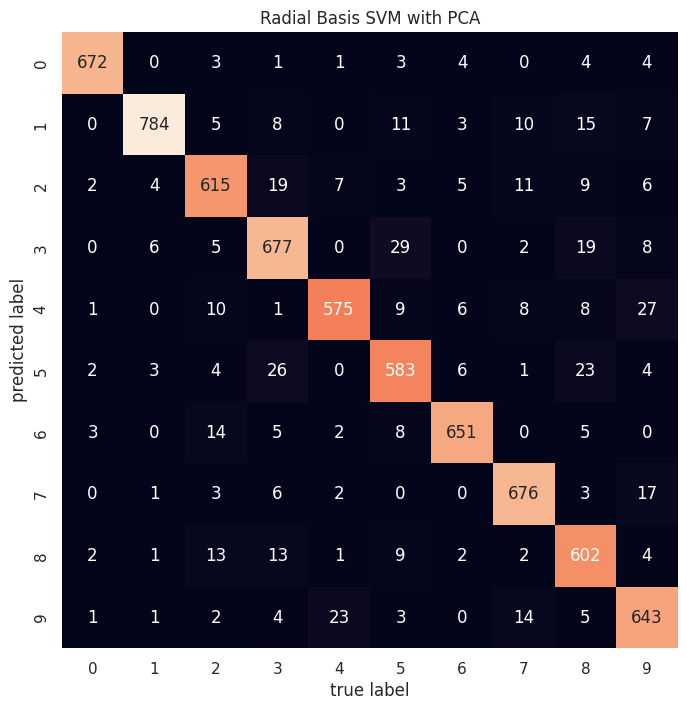

In [ ]:
learning_algo = RadialBasisSvmPcaLearningAlgorithm(n_components=71, cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


# At n_components = 75

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.93      0.98      0.95       800
           2       0.91      0.91      0.91       674
           3       0.90      0.89      0.90       760
           4       0.89      0.94      0.92       611
           5       0.89      0.89      0.89       658
           6       0.95      0.96      0.95       677
           7       0.96      0.94      0.95       724
           8       0.93      0.87      0.90       693
           9       0.93      0.90      0.91       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 1min 55s, sys: 2.46 s, total: 1min 57s
Wall time: 1min 55s
Top 3 pairs of confusion:
Class 3 vs. Class 5: 28 misclassifications
Class 4 vs. Class 9: 24 misclassifications
Class 2 vs. Class 6: 15 misclassifications


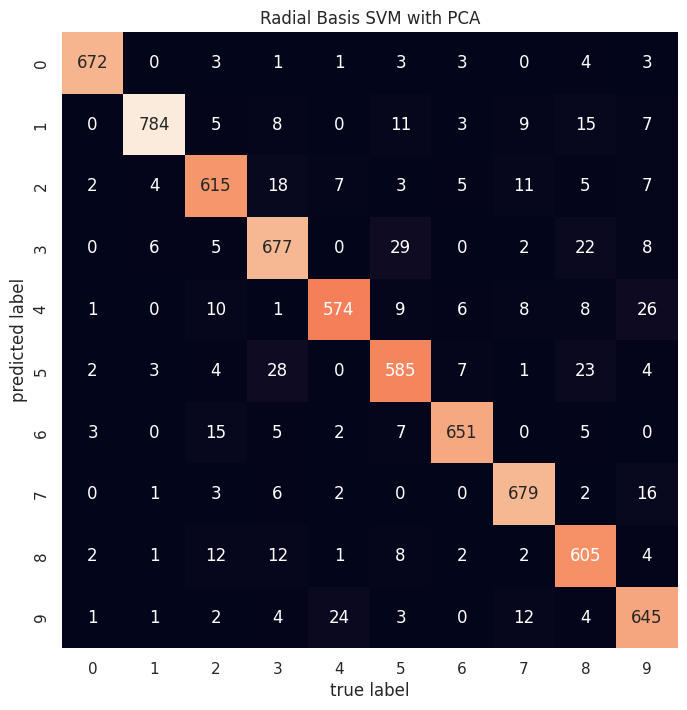

In [ ]:
learning_algo = RadialBasisSvmPcaLearningAlgorithm(n_components=75, cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)
y_pred = learning_algo.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Identify the top 3 pairs of confusion
top_3_pairs = []
for i in range(cm.shape[0]):
  for j in range(i + 1, cm.shape[1]):
    top_3_pairs.append((i, j, cm[i, j]))

# Sort the pairs of classes by the number of misclassifications, in descending order
top_3_pairs = sorted(top_3_pairs, key=lambda x: x[2], reverse=True)

# Print the top 3 pairs of confusion
print('Top 3 pairs of confusion:')
for i in range(3):
  print('Class {} vs. Class {}: {} misclassifications'.format(top_3_pairs[i][0], top_3_pairs[i][1], top_3_pairs[i][2]))

##Question 3.
What is the minimum number of components required to achieve equivalent performance to basic SVM without PCA (2.1)?

In SVM with PCA, 71 components are the minimum number of components required to achieve the performance of 0.93 which is equivalent to basic SVM without PCA.

#3. Random Forest

In this section, we'll investigate the Random Forest algorithm that aggregates its answer using many decorrelated trees.

##3.1 Tuning the Random Forest (Task 4)
In the code black below, write an extension class to `BaseLearningAlgorithm` called `RandomForestLearningAlgorithm` using Scikit-Learn's RandomForestClassifier. You should parameterize the class with the number of estimators (i.e., number of trees), type of split (gini or entropy), max tree depth, minimum number of samples per node.

Without doing a formal hyperparameter tuning, like grid search, try a few variations to improve overall accuracy.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       683
           1       0.97      0.98      0.98       800
           2       0.94      0.97      0.96       674
           3       0.95      0.95      0.95       760
           4       0.96      0.96      0.96       611
           5       0.97      0.96      0.96       658
           6       0.98      0.98      0.98       677
           7       0.97      0.96      0.96       724
           8       0.96      0.95      0.95       693
           9       0.95      0.94      0.95       720

    accuracy                           0.96      7000
   macro avg       0.96      0.96      0.96      7000
weighted avg       0.96      0.96      0.96      7000

CPU times: user 9min 19s, sys: 500 ms, total: 9min 20s
Wall time: 9min 22s
Top 3 pairs of confusion:
Class 4 vs. Class 9: 16 misclassifications
Class 5 vs. Class 8: 9 misclassifications
Class 7 vs. Class 9: 8 misclassifications


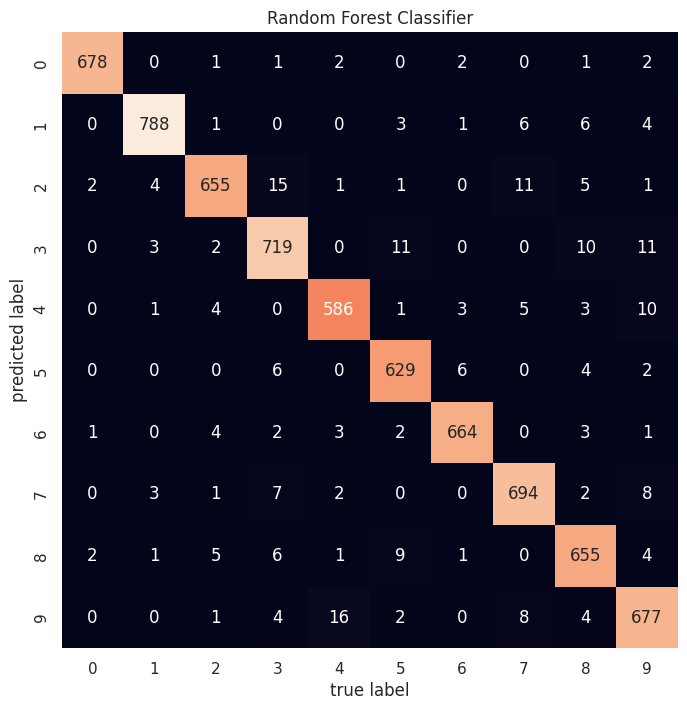

In [ ]:
class RandomForestLearningAlgorithm(BaseLearningAlgorithm):
  def __init__(self, n_estimators: int, criterion: str, max_depth: int, min_samples_split: int):
    self.clf = RandomForestClassifier(n_estimators=n_estimators, criterion = criterion, max_depth=max_depth, min_samples_split=min_samples_split)

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self.clf.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
    return self.clf.predict(x_test)

  @property
  def name(self) -> str:
    return 'Random Forest Classifier'
#Hyperparameter Tuning

#learning_algo = RandomForestLearningAlgorithm(n_estimators = 100, criterion = 'gini', max_depth = 5, min_samples_split = 2) Accuracy is 0.86

#On Increasing n_estimators
#learning_algo = RandomForestLearningAlgorithm(n_estimators=200, criterion='gini', max_depth=5, min_samples_split=2) Accuracy is 0.86

# On Increasing max_depth
#learning_algo = RandomForestLearningAlgorithm(n_estimators=100, criterion='gini', max_depth=10, min_samples_split=2) Accuracy is 0.94

#learning_algo = RandomForestLearningAlgorithm(n_estimators=1000, criterion='gini', max_depth=10, min_samples_split=3)   Accuracy is 0.95

# On Increasing n_estimators
learning_algo = RandomForestLearningAlgorithm(n_estimators=1500, criterion='gini', max_depth=15, min_samples_split=3) #0.96

%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)
y_pred = learning_algo.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Identify the top 3 pairs of confusion
top_3_pairs = []
for i in range(cm.shape[0]):
  for j in range(i + 1, cm.shape[1]):
    top_3_pairs.append((i, j, cm[i, j]))

# Sort the pairs of classes by the number of misclassifications, in descending order
top_3_pairs = sorted(top_3_pairs, key=lambda x: x[2], reverse=True)

# Print the top 3 pairs of confusion
print('Top 3 pairs of confusion:')
for i in range(3):
  print('Class {} vs. Class {}: {} misclassifications'.format(top_3_pairs[i][0], top_3_pairs[i][1], top_3_pairs[i][2]))

##Question 4.
What are the top three pairs of confusion (i.e., true row $i$, predicted column $j$), and are they the same as SVM? Why are these classes confused with each other?

The top three pairs of confusion for the random forest classifier are:
Top 3 pairs of confusion:
Class 4 vs. Class 9: 16 misclassifications
Class 5 vs. Class 8: 9 misclassifications
Class 7 vs. Class 9: 8 misclassifications

This means that the model is most often confusing Class 4 with Class 9, Class 5 with Class 8, and Class 7 with Class 9.

These are NOT same as SVM.
Top 3 pairs of confusion of SVM:
Class 3 vs. Class 5: 28 misclassifications
Class 4 vs. Class 9: 24 misclassifications
Class 2 vs. Class 6: 15 misclassifications

The reasons for these classes confused with each other are
* the confused classes may share similar features that make it difficult for the classifiers to distinguish between them.
* the confused classes may have different features that overlaps with each other resulting hard for the models to make accurate predictions.

So, this can result in higher confusion rates between classes with similar or overlapping features.

#4. Feedforward Neural Networks

In this section, we'll explore feedforward neural networks. First, we'll make some enhancements to a NN written using just numpy to give you a sense for how forward and back-propagation work, and how the weights are optimized using basic gradient descent.



##4.1 Neural network without libraries (Task 5)
Study the complete neural network implementation below. The architecture has an input width of 784 nodes, two hidden layers, and a softmax output layer of with 10 nodes (0-9).
Pay attention to the gradient calculation and the overall backpropagation algorithm, and how gradient descent adjusts the weights. Implement the ReLU activation funtion in the skeleton method provided below and compare the results to the sigmoid activation function.

In [11]:
class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001, activation='relu'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.activation = activation  # For Choosing either 'relu' or 'sigmoid' as the activation function

        # Saving all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
        return 1 / (1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        else:
            return np.where(x > 0, x, 0)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations become a sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        if self.activation == 'relu':
            params['A1'] = self.relu(params['Z1'])
        elif self.activation == 'sigmoid':
            params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        if self.activation == 'relu':
            params['A2'] = self.relu(params['Z2'])
        elif self.activation == 'sigmoid':
            params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to the output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Performs backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z2'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z1'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to the update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output match the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
        """Predicts on a test set."""
        return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        y_train = to_categorical(y_train)
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration + 1, time.time() - start_time, accuracy * 100
            ))

    @property
    def name(self) -> str:
        return 'Basic Neural Network'

### Neural Network with Sigmoid Activation Function

Epoch: 1, Time Spent: 45.08s, Validation Accuracy: 23.21%
Epoch: 2, Time Spent: 87.85s, Validation Accuracy: 27.54%
Epoch: 3, Time Spent: 133.37s, Validation Accuracy: 31.17%
Epoch: 4, Time Spent: 176.22s, Validation Accuracy: 37.81%
Epoch: 5, Time Spent: 219.15s, Validation Accuracy: 42.21%
Epoch: 6, Time Spent: 274.61s, Validation Accuracy: 44.98%
Epoch: 7, Time Spent: 320.05s, Validation Accuracy: 47.00%
Epoch: 8, Time Spent: 363.38s, Validation Accuracy: 48.11%
Epoch: 9, Time Spent: 408.09s, Validation Accuracy: 49.62%
Epoch: 10, Time Spent: 451.36s, Validation Accuracy: 51.51%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.72      0.94      0.82       683
           1       0.49      0.98      0.66       800
           2       0.82      0.37      0.51       674
           3       0.52      0.82      0.64       760
           4       0.00      0.00      0.00       611
           5       0.00      0.00      0.00       658
           6       0.52      0.92      0.66       677
           7       0.41      0.92      0.57       724
           8       1.00      0.03      0.05       693
           9       0.46      0.13      0.20       720

    accuracy                           0.53      7000
   macro avg       0.49      0.51      0.41      7000
weighted avg       0.50      0.53      0.42      7000

CPU times: user 7min 15s, sys: 5min 29s, total: 12min 45s
Wall time: 7min 32s


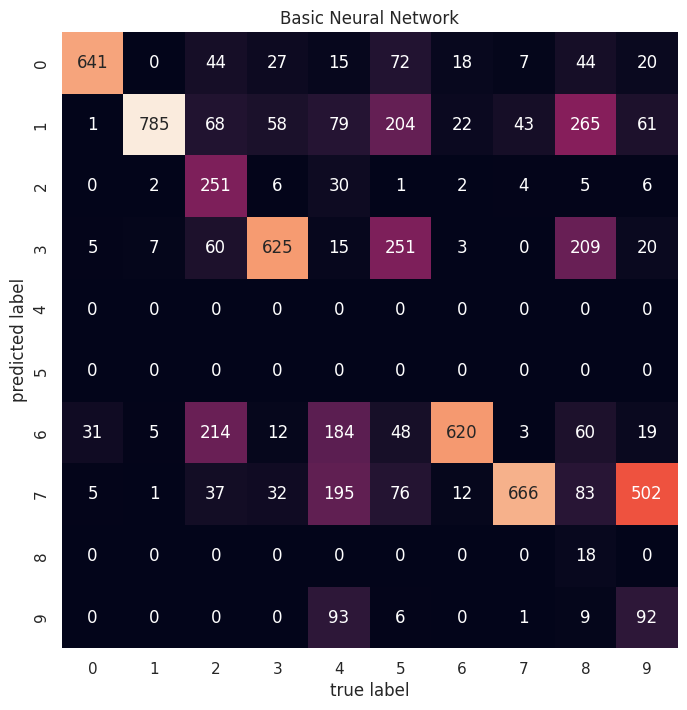

In [ ]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, activation='sigmoid')
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

### Confusion pairs for Neural Network using Sigmoid Func

Epoch: 1, Time Spent: 47.60s, Validation Accuracy: 19.57%
Epoch: 2, Time Spent: 93.10s, Validation Accuracy: 28.44%
Epoch: 3, Time Spent: 140.47s, Validation Accuracy: 30.97%
Epoch: 4, Time Spent: 183.93s, Validation Accuracy: 37.02%
Epoch: 5, Time Spent: 228.26s, Validation Accuracy: 42.08%
Epoch: 6, Time Spent: 272.75s, Validation Accuracy: 45.22%
Epoch: 7, Time Spent: 318.41s, Validation Accuracy: 48.14%
Epoch: 8, Time Spent: 365.15s, Validation Accuracy: 51.02%
Epoch: 9, Time Spent: 408.33s, Validation Accuracy: 53.94%
Epoch: 10, Time Spent: 451.55s, Validation Accuracy: 57.16%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      0.98      0.71       683
           1       0.50      0.98      0.67       800
           2       1.00      0.09      0.16       674
           3       0.47      0.85      0.61       760
           4       0.57      0.89      0.70       611
           5       0.00      0.00      0.00       658
           6       0.72      0.77      0.74       677
           7       0.96      0.38      0.55       724
           8       0.93      0.09      0.17       693
           9       0.59      0.63      0.61       720

    accuracy                           0.57      7000
   macro avg       0.63      0.57      0.49      7000
weighted avg       0.63      0.57      0.49      7000

CPU times: user 7min 13s, sys: 5min 29s, total: 12min 43s
Wall time: 7min 32s
Top 3 pairs of confusion:
Class 7 vs. Class 9: 200 misclassifications
Class 2 vs. Class 6: 124 misclassifications
Class 2 vs. Class 3: 103 misclassifications


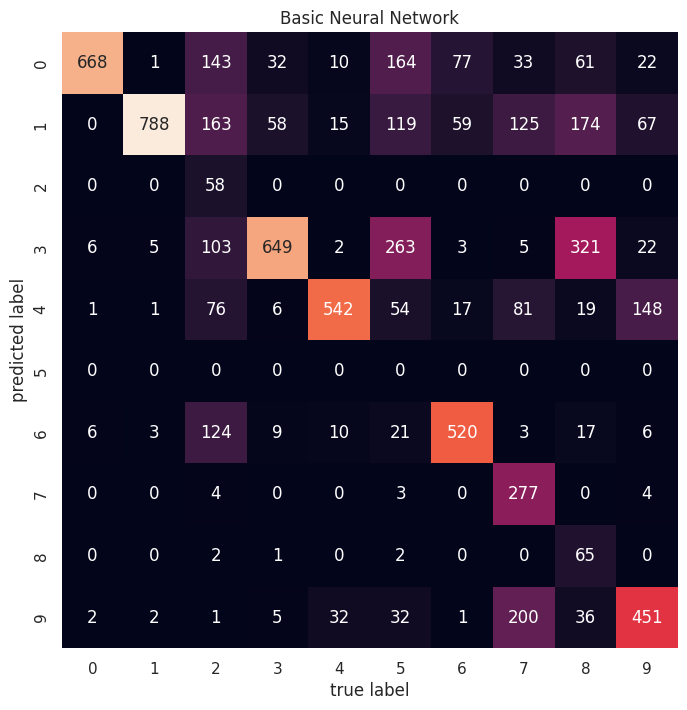

In [14]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, activation='sigmoid')
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

y_pred = learning_algo.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Identify the top 3 pairs of confusion
top_3_pairs = []
for i in range(cm.shape[0]):
  for j in range(i + 1, cm.shape[1]):
    top_3_pairs.append((i, j, cm[i, j]))

# Sort the pairs of classes by the number of misclassifications, in descending order
top_3_pairs = sorted(top_3_pairs, key=lambda x: x[2], reverse=True)

# Print the top 3 pairs of confusion
print('Top 3 pairs of confusion:')
for i in range(3):
  print('Class {} vs. Class {}: {} misclassifications'.format(top_3_pairs[i][0], top_3_pairs[i][1], top_3_pairs[i][2]))

### Neural Network with ReLU Activation Function

Epoch: 1, Time Spent: 37.83s, Validation Accuracy: 69.48%
Epoch: 2, Time Spent: 88.66s, Validation Accuracy: 83.38%
Epoch: 3, Time Spent: 126.98s, Validation Accuracy: 86.63%
Epoch: 4, Time Spent: 165.20s, Validation Accuracy: 88.32%
Epoch: 5, Time Spent: 205.20s, Validation Accuracy: 89.22%
Epoch: 6, Time Spent: 243.60s, Validation Accuracy: 89.75%
Epoch: 7, Time Spent: 281.81s, Validation Accuracy: 90.21%
Epoch: 8, Time Spent: 320.07s, Validation Accuracy: 90.70%
Epoch: 9, Time Spent: 373.17s, Validation Accuracy: 91.21%
Epoch: 10, Time Spent: 411.74s, Validation Accuracy: 91.52%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       683
           1       0.94      0.97      0.96       800
           2       0.92      0.87      0.89       674
           3       0.87      0.90      0.89       760
           4       0.90      0.91      0.91       611
           5       0.89      0.87      0.88       658
           6       0.94      0.9

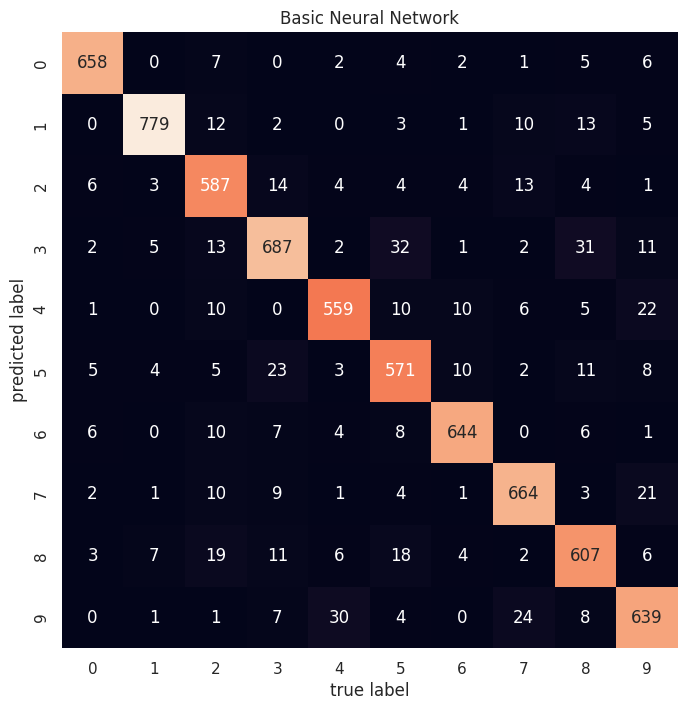

In [ ]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, activation='relu')
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

### Confusion pairs for Neural Network with ReLU

Epoch: 1, Time Spent: 54.54s, Validation Accuracy: 69.49%
Epoch: 2, Time Spent: 97.73s, Validation Accuracy: 81.48%
Epoch: 3, Time Spent: 140.50s, Validation Accuracy: 85.46%
Epoch: 4, Time Spent: 183.85s, Validation Accuracy: 87.57%
Epoch: 5, Time Spent: 227.88s, Validation Accuracy: 88.84%
Epoch: 6, Time Spent: 271.50s, Validation Accuracy: 89.81%
Epoch: 7, Time Spent: 313.49s, Validation Accuracy: 90.63%
Epoch: 8, Time Spent: 355.41s, Validation Accuracy: 91.06%
Epoch: 9, Time Spent: 398.78s, Validation Accuracy: 91.48%
Epoch: 10, Time Spent: 442.52s, Validation Accuracy: 91.90%
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       683
           1       0.94      0.97      0.96       800
           2       0.92      0.87      0.89       674
           3       0.86      0.92      0.88       760
           4       0.88      0.91      0.90       611
           5       0.88      0.86      0.87       658
           6       0.93      0.9

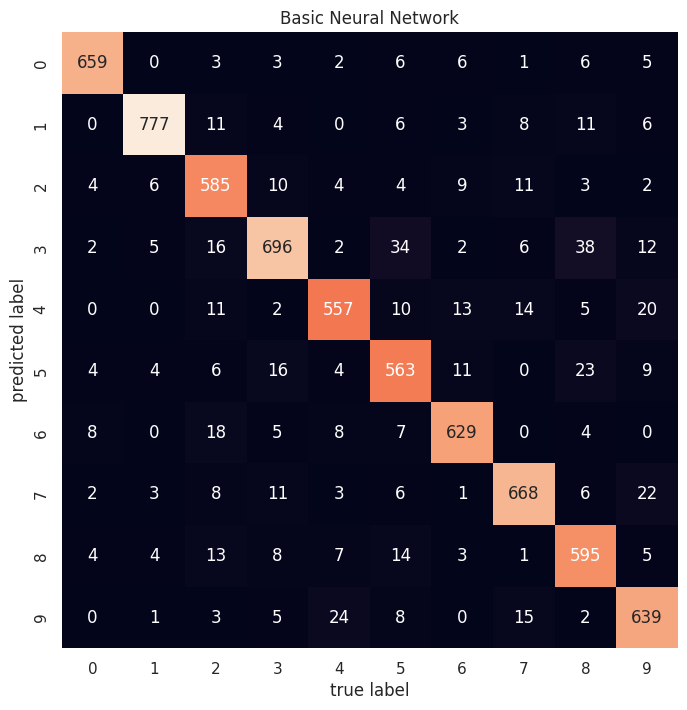

In [15]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, activation='relu')
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

y_pred = learning_algo.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Identify the top 3 pairs of confusion
top_3_pairs = []
for i in range(cm.shape[0]):
  for j in range(i + 1, cm.shape[1]):
    top_3_pairs.append((i, j, cm[i, j]))

# Sort the pairs of classes by the number of misclassifications, in descending order
top_3_pairs = sorted(top_3_pairs, key=lambda x: x[2], reverse=True)

# Print the top 3 pairs of confusion
print('Top 3 pairs of confusion:')
for i in range(3):
  print('Class {} vs. Class {}: {} misclassifications'.format(top_3_pairs[i][0], top_3_pairs[i][1], top_3_pairs[i][2]))

##Question 5.
When executing multiple times (using ReLU or sigmoid activations) for a fixed number of iterations, how much does the validation accuracy vary at the end of the training? What is causing the variation in performance?

# Answer

On executing multiple times using sigmoid activation, accuracies were 0.47, 0.53, then 0.62, 0.56, 0.59, 0.53 and finally 0.57.

At the same time, using relu activation, accuracy changes were 0.79, 0.81, 0.89, and 0.91.

Finally at the ending of running, **performance of the model using sigmoid activation is 57.10% and ReLU activation function is 91.52%**. There is almost 40% variation in their performances.

Here, the weights of the neural network are initialized randomly at the start of training. Because of this the model will learn differently each time you train it, even after using the same training data and hyperparameters.

This random initialization of the weights is used to disrupt the symmetry and to provide higher accuracy. It stops neurons from picking up on the same characteristics as their inputs. And as it can quickly memorize the training data, a neural network may prone to overfitting.

## Question 6.
Does the choice of activation function (ReLU vs. sigmoid) make any difference in validation accuracy?

# Answer

Yes on using the sigmoid function as hidden layers, validation accuracy is 51.55% and on using the RelU function as hidden layers, validation accuracy is 91.52%%
So, activation function surely makes difference in validation accuracy.

ReLU activation function can give higher validation accuracies than sigmoid activation as it can prevent vanishing gradients when training deep networks unlike sigmoid where it causes problems with vanishing gradients. And ReLU has faster run time than sigmoid.

Additionally, ReLU works well in situations where the input data is sparse. This sparsity can be advantageous as it can help to reduce overfitting and improve generalization performance.

##4.2 Feedforward Neural Network with Keras and Tensorflow (Task 6)
Next, set up and train a feedforward neural network in [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/).



1.   Paramaterize your model with the number of hidden layers, epochs, learning rate, and activation function.
2.   Add **early stopping** and add a patience parameter. You can apply the [keras callback function](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to implement early stopping.
3.   Apply sparse categorical entropy loss function.
4.   Apply Adaptive Moments (Adam) optimizer






In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
class FeedforwardNeuralNetworkAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, num_hidden_layers, hidden_layer_size, epochs =10, activation='relu', l_rate=0.001, early_stopping = True, patience=10):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.epochs = epochs
        self.l_rate = l_rate
        self.activation = activation
        self.early_stopping = early_stopping
        self.patience = patience
        self.sizes = sizes


        # Saving all parameters in the neural network in this dictionary
        self.params = self.initialization()
    #def sigmoid(self, x, derivative=False):
        #if derivative:
            #return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
        #return 1 / (1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        else:
            return np.where(x > 0, x, 0)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations become a sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        if self.activation == 'relu':
            params['A1'] = self.relu(params['Z1'])
        elif self.activation == 'sigmoid':
            params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        if self.activation == 'relu':
            params['A2'] = self.relu(params['Z2'])
        elif self.activation == 'sigmoid':
            params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to the output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Performs backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z2'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z1'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to the update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output match the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
        """Predicts on a test set."""
        return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def create_model(self, input_dim, num_classes):
        model = Sequential()
        model.add(Dense(self.hidden_layer_size, input_dim=input_dim, activation=self.activation))

        for _ in range(self.num_hidden_layers - 1):
            model.add(Dense(self.hidden_layer_size, activation=self.activation))

        model.add(Dense(num_classes, activation='softmax'))
        return model
    def fit(self, x_train, y_train, x_val, y_val, early_stopping = True, patience = 15):
        y_train = to_categorical(y_train)
        start_time = time.time()

        best_val_accuracy = 0.0
        epochs_without_improv = 0

        num_classes = len(np.unique(y_train))

        # Define your model

        model = self.create_model(x_train.shape[1], num_classes)

        # Compile the model with the Adam optimizer and SparseCategoricalCrossentropy loss
        optimizer = Adam(learning_rate=self.l_rate)
        model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            val_accuracy = self.compute_accuracy(x_val, y_val)

            if val_accuracy > best_val_accuracy:
              best_val_accuracy = val_accuracy
              epochs_without_improv = 0
            else:
              epochs_without_improv +=1

            # If the number of epochs without improvement exceeds the patience, stop training.
            if epochs_without_improv >= self.patience:
                if self.early_stopping:
                    print('Early stopping at epoch {}'.format(iteration + 1))
                    break

            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration + 1, time.time() - start_time, accuracy * 100
            ))

    @property
    def name(self) -> str:
        return 'Feedforward Neural Network'

Epoch: 1, Time Spent: 47.70s, Validation Accuracy: 69.06%
Epoch: 2, Time Spent: 93.94s, Validation Accuracy: 78.51%
Epoch: 3, Time Spent: 137.68s, Validation Accuracy: 86.71%
Epoch: 4, Time Spent: 183.25s, Validation Accuracy: 88.65%
Epoch: 5, Time Spent: 230.72s, Validation Accuracy: 89.83%
Epoch: 6, Time Spent: 276.53s, Validation Accuracy: 90.51%
Epoch: 7, Time Spent: 321.23s, Validation Accuracy: 90.98%
Epoch: 8, Time Spent: 365.77s, Validation Accuracy: 91.35%
Epoch: 9, Time Spent: 411.75s, Validation Accuracy: 91.52%
Epoch: 10, Time Spent: 457.66s, Validation Accuracy: 91.79%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       683
           1       0.94      0.97      0.96       800
           2       0.88      0.90      0.89       674
           3       0.89      0.90      0.90       760
           4       0.89      0.92      0.91       611
           5       0.88      0.89      0.89       658
           6       0.94      0.9

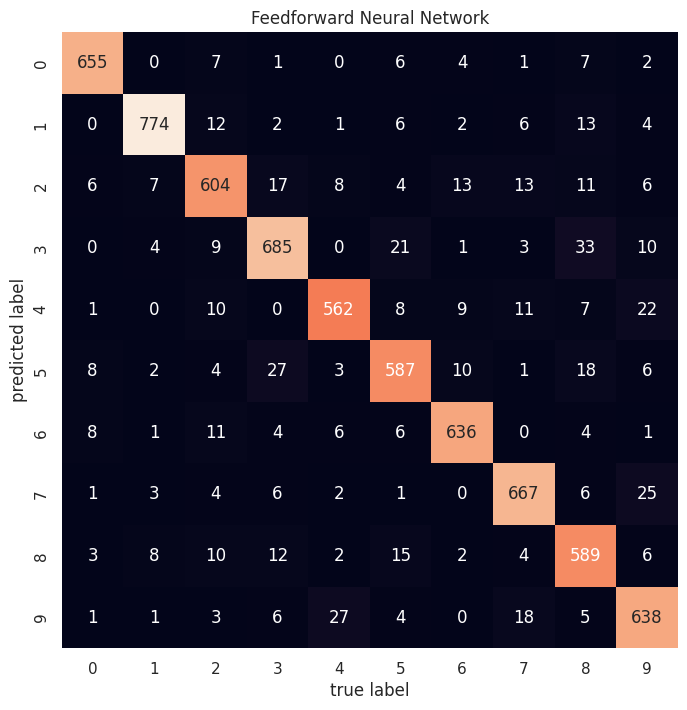

In [ ]:
learning_algo = FeedforwardNeuralNetworkAlgorithm (sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, activation='relu', num_hidden_layers = 2, hidden_layer_size=128, early_stopping = True, patience=15)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

### Confusion Pairs for FNN

Epoch: 1, Time Spent: 46.79s, Validation Accuracy: 73.65%
Epoch: 2, Time Spent: 92.48s, Validation Accuracy: 83.25%
Epoch: 3, Time Spent: 137.37s, Validation Accuracy: 86.24%
Epoch: 4, Time Spent: 180.75s, Validation Accuracy: 88.11%
Epoch: 5, Time Spent: 227.34s, Validation Accuracy: 89.06%
Epoch: 6, Time Spent: 269.65s, Validation Accuracy: 89.97%
Epoch: 7, Time Spent: 315.69s, Validation Accuracy: 90.33%
Epoch: 8, Time Spent: 358.68s, Validation Accuracy: 90.89%
Epoch: 9, Time Spent: 409.39s, Validation Accuracy: 91.27%
Epoch: 10, Time Spent: 453.48s, Validation Accuracy: 91.51%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       683
           1       0.94      0.97      0.95       800
           2       0.91      0.88      0.90       674
           3       0.89      0.89      0.89       760
           4       0.90      0.91      0.91       611
           5       0.90      0.87      0.88       658
           6       0.94      0.9

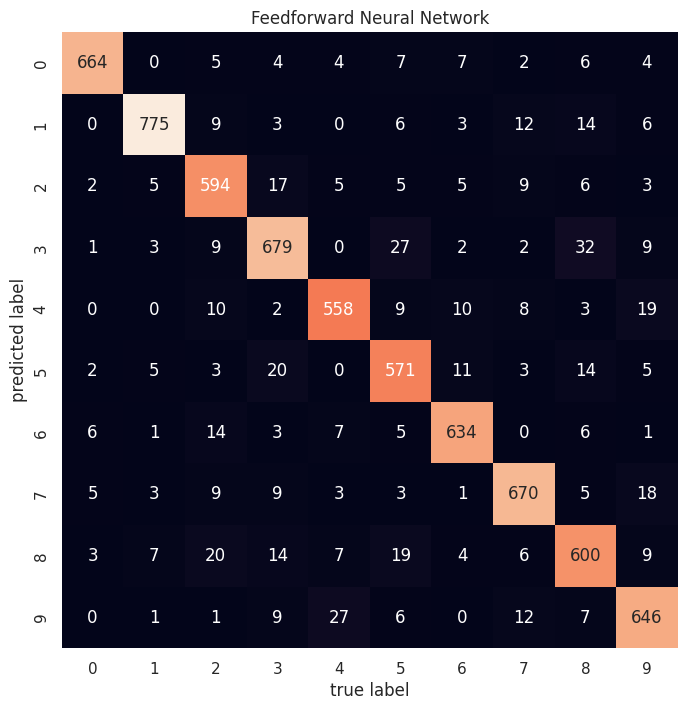

In [18]:
learning_algo = FeedforwardNeuralNetworkAlgorithm (sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, activation='relu', num_hidden_layers = 2, hidden_layer_size=128, early_stopping = True, patience=15)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

y_pred = learning_algo.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Identify the top 3 pairs of confusion
top_3_pairs = []
for i in range(cm.shape[0]):
  for j in range(i + 1, cm.shape[1]):
    top_3_pairs.append((i, j, cm[i, j]))

# Sort the pairs of classes by the number of misclassifications, in descending order
top_3_pairs = sorted(top_3_pairs, key=lambda x: x[2], reverse=True)

# Print the top 3 pairs of confusion
print('Top 3 pairs of confusion:')
for i in range(3):
  print('Class {} vs. Class {}: {} misclassifications'.format(top_3_pairs[i][0], top_3_pairs[i][1], top_3_pairs[i][2]))

##Question 6
Summarize the results of all your classifiers. Which classifiers performed better or worse than the logistic regression benchmark? Which method executed fastest in terms of time? Which was easiest to set up and parameterize? Which classes tended to get most often confused across all classifiers?

# Answer

For Logistic Regression, Accuracy is 0.92

For SVM without PCA, Accuracy is 0.93

For SVM with PCA, Accuracy is 0.91

For Random Forest, Accuracy is 0.96

For Neural Networks using Sigmoid Activation Function, Accuracy is 0.57

For Neural Networks using ReLU Activation Function, Accuracy is 0.91

For FeedForward Neural Network with Keras & Tensorflow, Accuracy is 0.93

Neural Network using the Sigmoid activation function done worse than Logistic Regression and remaining all classifiers have given similar performance whereas Random Forest gave the higher performance than all.

* SVM with PCA executed so fastly within 1 min 34s total time compared to all other classifiers.

* Logistic regression is easiest to setup than others. As for the others we should do the  hyperparameter tuning like changing epochs, n_estimators, learning rate and using different activation functions and more. And also should clearly look for the overfitting while setting these parameters.

Confused classes for every classifier:

For Logistic Regression, **(3,5) (5,8) (2,8)**

For SVM without PCA, **(4,9) (3,5) (2,4)**

For SVM with PCA, **(3,5) (4,9) (2,6)**

For Random Forest, **(4,9) (5,9) (7,9)**

For Neural Networks using Sigmoid Activation Function, **(7,9) (2,6) (2,3)**

For Neural Networks using ReLU Activation Function, **(4,9) (2,6) (2,3)**

For FeedForward Neural Network with Keras & Tensorflow, **(4,9) (2,8) (3,5)**



**Classes (3 & 5) and Classes (4 & 9) are confusing most often.**

#Optional Extra Credit (max course credit: 3%)


*   Implement early stopping in 4.1 (**1% extra credit**).
*   Add in one or more Keras dropout layers in 4.2 (**1% extra credit**).
*   Implement mini-batch gradient descent in 4.1, replacing stochastic gradient descent. Instead of making an update to a parameter for each sample, make an update based on the averaged value of each sample in a mini-batch. The size of the mini-batch is usually below 64. (**3% extra credit**)
*  Initialize biases and add them to Z in 4.1 before the activation function in the forward pass, and update the biases in the backward pass.  (**2% extra credit**)




## **Implementing Early Stopping in 4.1**

In [ ]:
class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001, activation='relu', early_stopping=False, patience=10):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.activation = activation  # For Choosing either 'relu' or 'sigmoid' as the activation function
        self.early_stopping = early_stopping
        self.patience = patience
        # Saving all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
        return 1 / (1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        else:
            return np.where(x > 0, x, 0)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations become a sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        if self.activation == 'relu':
            params['A1'] = self.relu(params['Z1'])
        elif self.activation == 'sigmoid':
            params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        if self.activation == 'relu':
            params['A2'] = self.relu(params['Z2'])
        elif self.activation == 'sigmoid':
            params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to the output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Performs backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z2'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z1'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to the update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output match the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
        """Predicts on a test set."""
        return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        y_train = to_categorical(y_train)
        start_time = time.time()

        best_val_accuracy = 0.0
        epochs_without_improv = 0

        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            val_accuracy = self.compute_accuracy(x_val, y_val)

            if val_accuracy > best_val_accuracy:
              best_val_accuracy = val_accuracy
              epochs_without_improv = 0
            else:
              epochs_without_improv +=1

            # If the number of epochs without improvement exceeds the patience, stop training.
            if epochs_without_improv >= self.patience:
                if self.early_stopping:
                    print('Early stopping at epoch {}'.format(iteration + 1))
                    break

            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration + 1, time.time() - start_time, accuracy * 100
            ))

    @property
    def name(self) -> str:
        return 'Basic Neural Network'

**ReLU**

Epoch: 1, Time Spent: 41.24s, Validation Accuracy: 73.43%
Epoch: 2, Time Spent: 79.59s, Validation Accuracy: 83.56%
Epoch: 3, Time Spent: 118.44s, Validation Accuracy: 86.71%
Epoch: 4, Time Spent: 157.10s, Validation Accuracy: 88.14%
Epoch: 5, Time Spent: 197.05s, Validation Accuracy: 89.06%
Epoch: 6, Time Spent: 234.46s, Validation Accuracy: 89.87%
Epoch: 7, Time Spent: 270.64s, Validation Accuracy: 90.41%
Epoch: 8, Time Spent: 307.19s, Validation Accuracy: 90.78%
Epoch: 9, Time Spent: 344.00s, Validation Accuracy: 91.08%
Epoch: 10, Time Spent: 380.85s, Validation Accuracy: 91.35%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       683
           1       0.94      0.97      0.96       800
           2       0.90      0.88      0.89       674
           3       0.87      0.90      0.89       760
           4       0.90      0.91      0.90       611
           5       0.89      0.86      0.88       658
           6       0.94      0.9

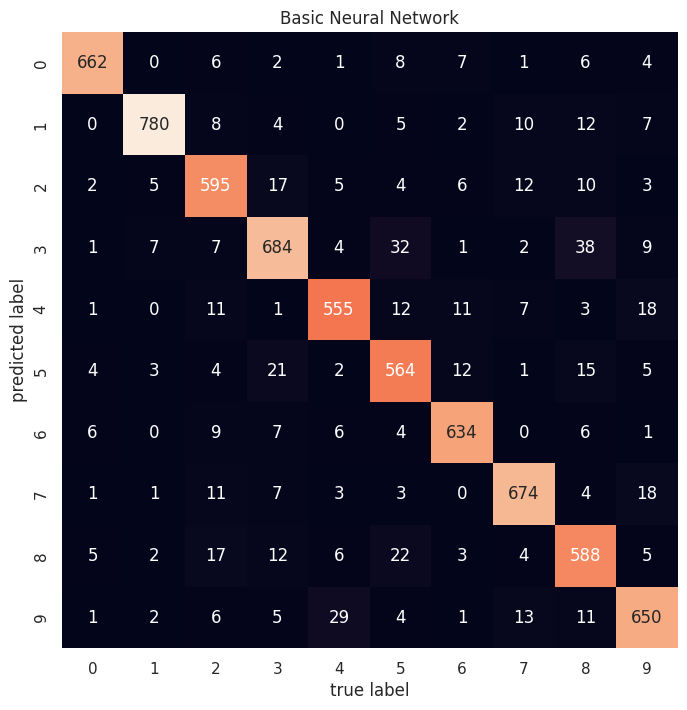

In [ ]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, activation='relu', early_stopping = True, patience =10)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

**Sigmoid**

Epoch: 1, Time Spent: 47.62s, Validation Accuracy: 22.56%
Epoch: 2, Time Spent: 89.81s, Validation Accuracy: 31.05%
Epoch: 3, Time Spent: 131.30s, Validation Accuracy: 34.22%
Epoch: 4, Time Spent: 171.24s, Validation Accuracy: 36.17%
Epoch: 5, Time Spent: 211.95s, Validation Accuracy: 38.94%
Epoch: 6, Time Spent: 252.36s, Validation Accuracy: 42.14%
Epoch: 7, Time Spent: 293.27s, Validation Accuracy: 45.48%
Epoch: 8, Time Spent: 335.38s, Validation Accuracy: 49.16%
Epoch: 9, Time Spent: 376.76s, Validation Accuracy: 52.83%
Epoch: 10, Time Spent: 416.95s, Validation Accuracy: 55.62%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.52      0.95      0.67       683
           1       0.50      0.99      0.66       800
           2       0.83      0.41      0.55       674
           3       0.67      0.58      0.62       760
           4       0.51      0.74      0.61       611
           5       0.00      0.00      0.00       658
           6       0.59      0.88      0.71       677
           7       0.51      0.81      0.63       724
           8       0.93      0.19      0.31       693
           9       0.00      0.00      0.00       720

    accuracy                           0.56      7000
   macro avg       0.51      0.55      0.48      7000
weighted avg       0.51      0.56      0.48      7000

CPU times: user 6min 45s, sys: 5min 2s, total: 11min 47s
Wall time: 6min 58s


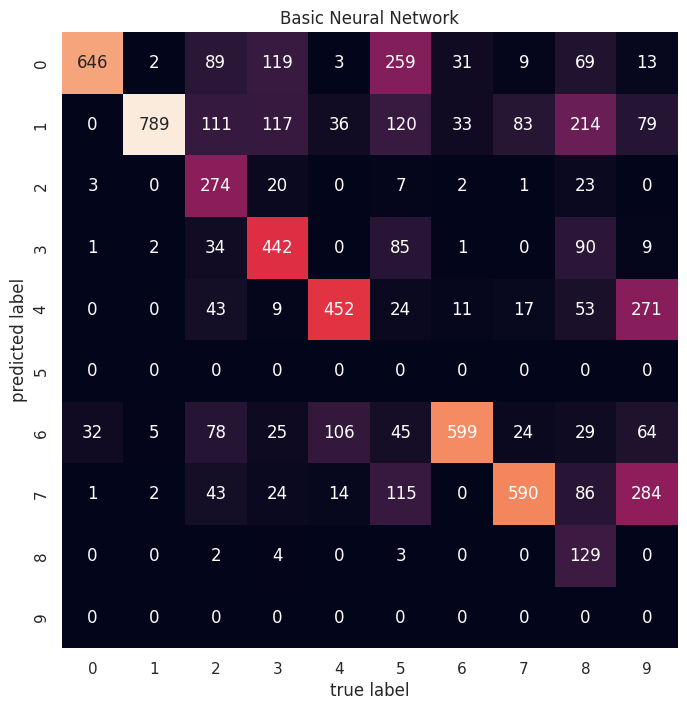

In [ ]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, activation='sigmoid', early_stopping = True, patience =10)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

### Tried with different epoch values and also tried increasing the patience to see if the early stopping works but still the early stopping did not stop the process. The validation accuracy had improved for every epoch.

## **Dropout Layer** 4.2

In [ ]:
class FeedforwardNeuralNetworkAlgorithmD(BaseLearningAlgorithm):
    def __init__(self, sizes,epochs =10, activation='relu', num_hidden_layers = 2, hidden_layer_size=128,dropout_rate =0.5, l_rate=0.001, early_stopping = True, patience=10):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.epochs = epochs
        self.dropout_rate = dropout_rate
        self.l_rate = l_rate
        self.activation = activation
        self.early_stopping = early_stopping
        self.patience = patience
        self.sizes = sizes


        # Saving all parameters in the neural network in this dictionary
        self.params = self.initialization()
    #def sigmoid(self, x, derivative=False):
        #if derivative:
            #return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
        #return 1 / (1 + np.exp(-x))


    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        else:
            return np.where(x > 0, x, 0)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations become a sample
        params['A0'] = x_train


        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #params['A1'] = np.dropout(self.relu(params['Z1']), self.dropout_rate)
        params['A1'] = tf.keras.layers.Dropout(self.dropout_rate)(self.relu(params['Z1']))

        # Dropout layer after the first hidden layer
        params['A1'] = tf.keras.layers.Dropout(self.dropout_rate)(params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.relu(params['Z2'])

        # hidden layer 2 to the output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Performs backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z2'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z1'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to the update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output match the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
        """Predicts on a test set."""
        return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def create_model(self, input_dim, num_classes):
        model = Sequential()
        model.add(Dense(self.hidden_layer_size, input_dim=input_dim, activation=self.activation))

        for _ in range(self.num_hidden_layers - 1):
            model.add(Dense(self.hidden_layer_size, activation=self.activation))

        model.add(Dense(num_classes, activation='softmax'))
        return model
    def fit(self, x_train, y_train, x_val, y_val, early_stopping=True, patience=20):
        y_train = to_categorical(y_train)
        start_time = time.time()

        best_val_accuracy = 0.0
        epochs_without_improv = 0

        num_classes = len(np.unique(y_train))
        # Create the model
        model = self.create_model(x_train.shape[1], len(np.unique(y_train)))

        # Compile the model
        optimizer = Adam(learning_rate=self.l_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            val_accuracy = self.compute_accuracy(x_val, y_val)

            if val_accuracy > best_val_accuracy:
              best_val_accuracy = val_accuracy
              epochs_without_improv = 0
            else:
              epochs_without_improv +=1

            # If the number of epochs without improvement exceeds the patience, stop training.
            if epochs_without_improv >= self.patience:
                if self.early_stopping:
                    print('Early stopping at epoch {}'.format(iteration + 1))
                    break

            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration + 1, time.time() - start_time, accuracy * 100
            ))

    @property
    def name(self) -> str:
        return 'Feedforward Neural Network'

Epoch: 1, Time Spent: 371.94s, Validation Accuracy: 73.70%
Epoch: 2, Time Spent: 738.60s, Validation Accuracy: 85.29%
Epoch: 3, Time Spent: 1107.62s, Validation Accuracy: 87.83%
Epoch: 4, Time Spent: 1476.01s, Validation Accuracy: 89.06%
Epoch: 5, Time Spent: 1844.88s, Validation Accuracy: 89.67%
Epoch: 6, Time Spent: 2213.93s, Validation Accuracy: 90.29%
Epoch: 7, Time Spent: 2596.89s, Validation Accuracy: 90.60%
Epoch: 8, Time Spent: 2971.06s, Validation Accuracy: 90.97%
Epoch: 9, Time Spent: 3346.12s, Validation Accuracy: 91.43%
Epoch: 10, Time Spent: 3722.44s, Validation Accuracy: 91.63%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       683
           1       0.94      0.97      0.96       800
           2       0.88      0.89      0.89       674
           3       0.89      0.90      0.89       760
           4       0.91      0.92      0.91       611
           5       0.89      0.91      0.90       658
           6       0.9

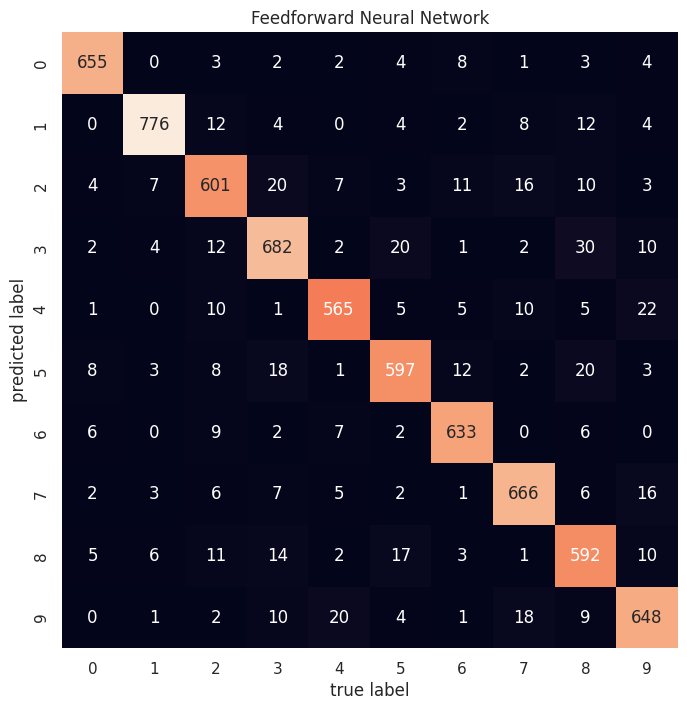

In [ ]:
learning_algo = FeedforwardNeuralNetworkAlgorithmD(sizes=[784, 128, 64, 10], epochs=10, num_hidden_layers = 2, hidden_layer_size=128,dropout_rate = 0.5, l_rate=0.001, activation='relu', early_stopping = True, patience=15)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

# **Mini Batch 4.1**

In [ ]:
class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001, activation='relu', batch_size = 54):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.activation = activation  # For Choosing either 'relu' or 'sigmoid' as the activation function
        self.batch_size = batch_size

        # Saving all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
        return 1 / (1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        else:
            return np.where(x > 0, x, 0)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations become a sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        if self.activation == 'relu':
            params['A1'] = self.relu(params['Z1'])
        elif self.activation == 'sigmoid':
            params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        if self.activation == 'relu':
            params['A2'] = self.relu(params['Z2'])
        elif self.activation == 'sigmoid':
            params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to the output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Performs backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z2'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error)
        if self.activation == 'relu':
            error *= self.relu(params['Z1'], derivative=True)
        elif self.activation == 'sigmoid':
            error *= self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to the update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output match the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
        """Predicts on a test set."""
        return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val, batch_size=32):
          y_train = to_categorical(y_train)
          start_time = time.time()

          for iteration in range(self.epochs):
              # Shuffle the training data to ensure randomness in each epoch
              indices = np.arange(len(x_train))
              np.random.shuffle(indices)
              x_train_shuffled = x_train[indices]
              y_train_shuffled = y_train[indices]

              # Split the training data into mini-batches using self.batch_size
              num_batches = len(x_train) // batch_size
              for batch in range(num_batches):
                  start = batch * batch_size
                  end = (batch + 1) * batch_size

                  x_batch = x_train_shuffled[start:end]
                  y_batch = y_train_shuffled[start:end]

                  # Initialize accumulators for parameter changes over the mini-batch
                  accumulated_changes = {key: np.zeros_like(value) for key, value in self.params.items()}

                  for x, y in zip(x_batch, y_batch):
                      output = self.forward_pass(x)
                      changes_to_w = self.backward_pass(y, output)

                      # Ensure all keys in self.params are considered
                      for key in self.params:
                          if key in changes_to_w:
                              accumulated_changes[key] += changes_to_w[key]

                  # Update the parameters based on the averaged changes over the mini-batch
                  for key in accumulated_changes:
                      self.params[key] -= self.l_rate * (accumulated_changes[key] / len(x_batch))

              # Calculate training accuracy and validation accuracy at the end of each epoch
              train_accuracy = self.compute_accuracy(x_train, y_train)
              validation_accuracy = self.compute_accuracy(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Training Accuracy: {2:.2f}%, Validation Accuracy: {3:.2f}%'.format(
                  iteration + 1, time.time() - start_time, train_accuracy * 100, validation_accuracy * 100
              ))

    @property
    def name(self) -> str:
        return 'Basic Neural Network'

at epochs = 15, l_rate= 0.01, activation='relu', batch_size=32

Epoch: 1, Time Spent: 42.21s, Training Accuracy: 5.41%, Validation Accuracy: 48.03%
Epoch: 2, Time Spent: 82.46s, Training Accuracy: 2.25%, Validation Accuracy: 64.05%
Epoch: 3, Time Spent: 124.43s, Training Accuracy: 1.43%, Validation Accuracy: 72.51%
Epoch: 4, Time Spent: 165.23s, Training Accuracy: 1.20%, Validation Accuracy: 78.52%
Epoch: 5, Time Spent: 206.01s, Training Accuracy: 1.16%, Validation Accuracy: 81.43%
Epoch: 6, Time Spent: 247.44s, Training Accuracy: 1.05%, Validation Accuracy: 83.10%
Epoch: 7, Time Spent: 289.70s, Training Accuracy: 0.98%, Validation Accuracy: 84.22%
Epoch: 8, Time Spent: 330.51s, Training Accuracy: 0.85%, Validation Accuracy: 85.35%
Epoch: 9, Time Spent: 371.96s, Training Accuracy: 0.80%, Validation Accuracy: 86.13%
Epoch: 10, Time Spent: 412.16s, Training Accuracy: 0.79%, Validation Accuracy: 86.73%
Epoch: 11, Time Spent: 452.52s, Training Accuracy: 0.73%, Validation Accuracy: 87.16%
Epoch: 12, Time Spent: 492.98s, Training Accuracy: 0.69%, Validat

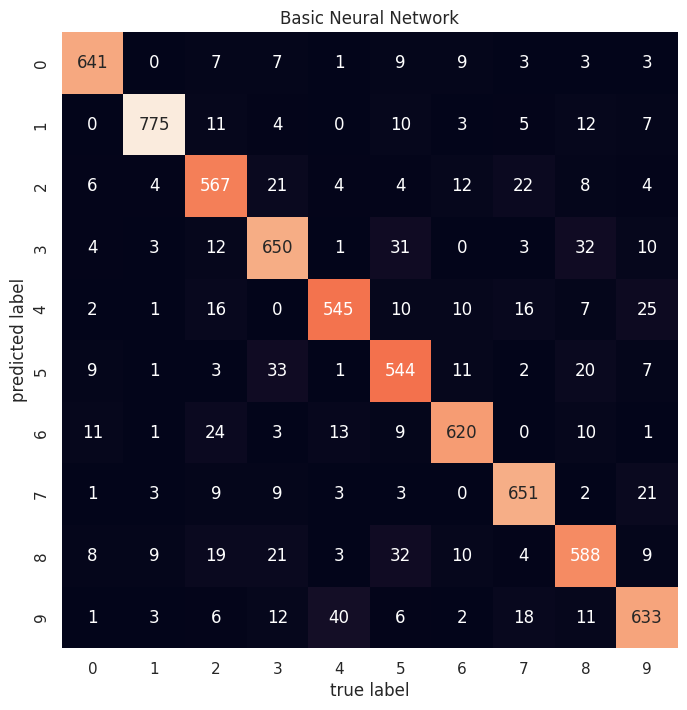

In [ ]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=15, l_rate=0.01, activation='relu', batch_size=32)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

at epochs=25, l_rate=0.01, activation='relu', batch_size=32

Epoch: 1, Time Spent: 45.59s, Training Accuracy: 6.63%, Validation Accuracy: 42.10%
Epoch: 2, Time Spent: 87.15s, Training Accuracy: 2.97%, Validation Accuracy: 61.52%
Epoch: 3, Time Spent: 127.83s, Training Accuracy: 1.46%, Validation Accuracy: 72.97%
Epoch: 4, Time Spent: 168.15s, Training Accuracy: 0.94%, Validation Accuracy: 78.49%
Epoch: 5, Time Spent: 208.29s, Training Accuracy: 0.90%, Validation Accuracy: 82.10%
Epoch: 6, Time Spent: 248.49s, Training Accuracy: 0.76%, Validation Accuracy: 84.08%
Epoch: 7, Time Spent: 289.11s, Training Accuracy: 0.71%, Validation Accuracy: 85.35%
Epoch: 8, Time Spent: 329.43s, Training Accuracy: 0.68%, Validation Accuracy: 86.29%
Epoch: 9, Time Spent: 370.16s, Training Accuracy: 0.71%, Validation Accuracy: 87.05%
Epoch: 10, Time Spent: 411.38s, Training Accuracy: 0.69%, Validation Accuracy: 87.67%
Epoch: 11, Time Spent: 452.02s, Training Accuracy: 0.58%, Validation Accuracy: 88.10%
Epoch: 12, Time Spent: 492.45s, Training Accuracy: 0.57%, Validat

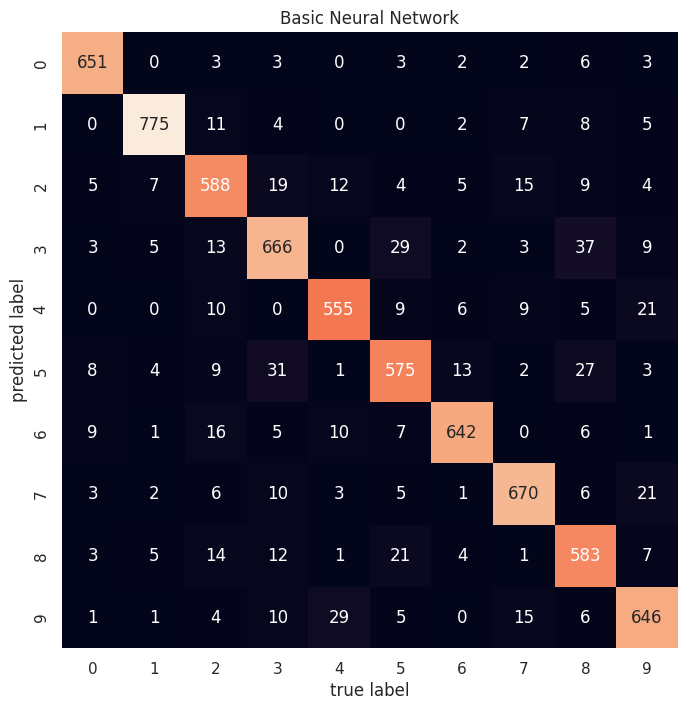

In [ ]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=25, l_rate=0.01, activation='relu', batch_size=32)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

at epochs=28, l_rate=0.01, activation='relu', batch_size=32

Epoch: 1, Time Spent: 44.20s, Training Accuracy: 11.50%, Validation Accuracy: 38.51%
Epoch: 2, Time Spent: 86.17s, Training Accuracy: 4.77%, Validation Accuracy: 57.49%
Epoch: 3, Time Spent: 127.43s, Training Accuracy: 2.19%, Validation Accuracy: 70.62%
Epoch: 4, Time Spent: 169.93s, Training Accuracy: 1.29%, Validation Accuracy: 77.90%
Epoch: 5, Time Spent: 210.36s, Training Accuracy: 1.22%, Validation Accuracy: 81.03%
Epoch: 6, Time Spent: 252.81s, Training Accuracy: 0.93%, Validation Accuracy: 83.17%
Epoch: 7, Time Spent: 294.09s, Training Accuracy: 0.86%, Validation Accuracy: 84.70%
Epoch: 8, Time Spent: 338.28s, Training Accuracy: 0.82%, Validation Accuracy: 85.70%
Epoch: 9, Time Spent: 379.03s, Training Accuracy: 0.79%, Validation Accuracy: 86.35%
Epoch: 10, Time Spent: 422.49s, Training Accuracy: 0.72%, Validation Accuracy: 86.81%
Epoch: 11, Time Spent: 463.33s, Training Accuracy: 0.76%, Validation Accuracy: 87.44%
Epoch: 12, Time Spent: 505.22s, Training Accuracy: 0.63%, Valida

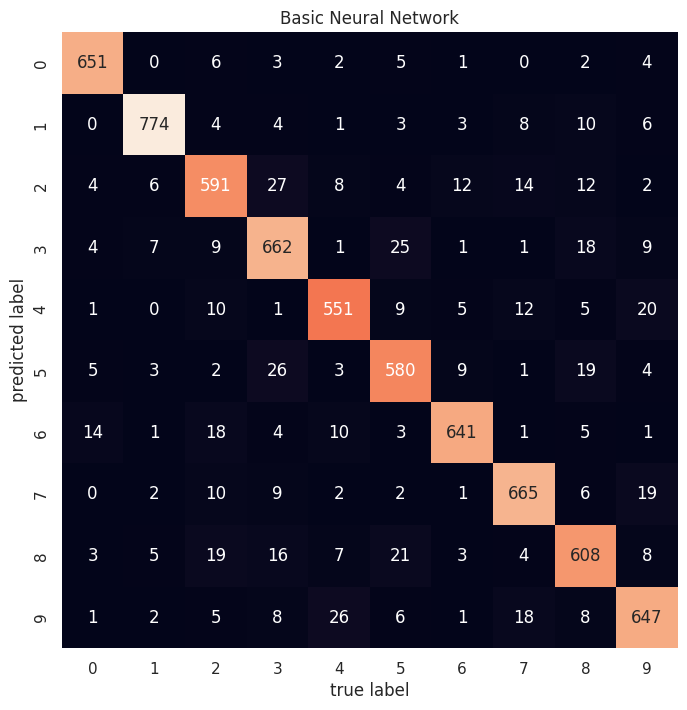

In [ ]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=28, l_rate=0.01, activation='relu', batch_size=32)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)